#  ATOC5860 Application Lab #2 - AR1_Nstar
##### Originally coded by Prof. Kay (CU) and Elizabeth Maroon (CU, now U.Wisc) with input from Hannah Zanowski (CU, now U.Wisc)
##### last updated February 10, 2023

### LEARNING GOALS:
1) Calculate the autocorrelation at a range of lags using two methods available in python (np.correlate, dot products)
2) Estimate the effective sample size (N*) using the lag-1 autocorrelation
3) Evaluate the influence of changing the sampling frequency and the specified weather variable on the memory/redness of the data as quantified by the autocorrelation and N*.


### DATA and UNDERLYING SCIENCE MOTIVATION:  
In this notebook, you will analyze the memory (red noise) in weather observations from Fort Colins, Colorado at Christman Field.  The observations are from one year, but are sampled hourly. The default settings for the notebook analyze the air temperature in degrees F sampled once daily (every midnight).  But other standard weather variables and sampling frequencies can also be easily analyzed.  The file containing the data is called **christman_2016.csv** and it is a comma-delimited text file.


### Non-exhaustive Questions to guide your analysis:  

1) Start with the default settings in the code.  In other words – Read in the data and find the air temperature every 24 hours (every midnight) over the entire year.  Calculate the lag-1 autocorrelation using np.correlate and the direct method using dot products.  Compare the python syntax for calculating the autocorrelation with the formulas in Barnes.  Equation numbers are provided to refer you back to the Barnes Notes. What is the lag-1 autocorrelation?  

2) Calculate the autocorrelation at a range of lags using np.correlate and the direct method using dot products.  Compare the python syntax for calculating the autocorrelation with the formulas in Barnes.  Equation numbers are provided to refer you back to the Barnes Notes. How does the autocorrelation change as you vary the lag from -40 days to +40 days?

3) Calculate the effective sample size (N*) and compare it to your original sample size (N). Equation numbers are provided to refer you back to the Barnes Notes.  How much memory is there in temperature sampled every midnight?

4) Now you are ready to tinker … i.e., make minor adjustments to the code with the parameters set in the code to see how your results change.  Suggestion: Make a copy of the notebook for your tinkering so that you can refer back to your original answers and the unmodified original code. For example: Repeat steps 1-3) above with a different variable (e.g., relative humidity (RH), wind speed (wind_mph)).  Repeat steps 1-3) above with a different temporal sampling frequency (e.g., every 12 hours, every 6 hours, every 4 days).  How do you answers change?  

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import xarray
import pandas as pd   ##pandas reads in .csv.
from scipy import stats
import seaborn as sns  ### seaborn just makes things pretty -- no new typing
sns.set_style('whitegrid')  ###  change away from grey grid (seaborn default) to white grid

## Non-exhaustive Questions to guide your analysis:  

### 1) Start with the default settings in the code.  In other words – Read in the data and find the air temperature every 24 hours (every midnight) over the entire year.  Calculate the lag-1 autocorrelation using np.correlate and the direct method using dot products.  Compare the python syntax for calculating the autocorrelation with the formulas in Barnes.  Equation numbers are provided to refer you back to the Barnes Notes. What is the lag-1 autocorrelation?  

- The lag-1 autocorrelation for hourly midnight temperatures in both methods is 0.846.

In [2]:
## Read in the data
filename = 'christman_2016.csv'
data=pd.read_csv(filename,sep=',')
data.head()

day      hour  temp_F    RH  dewtemp_F  wind_mph  wind_dir  windgust  \
0  42370  0.000000     7.0  72.2       -0.1       1.2       234       3.9   
1  42370  0.041667     5.4  74.3       -1.0       3.4       299       7.1   
2  42370  0.083333     6.4  73.8       -0.2       2.8       200       7.0   
3  42370  0.125000     3.0  73.5       -3.6       2.9       309       6.1   
4  42370  0.166667     3.7  76.9       -1.9       3.1       346       5.3   

   windgust_dir  pres_Hg  SOLIN_Wm2  Prec_inches  
0           224   851.30        0.0          0.0  
1           302   850.82        0.0          0.0  
2           301   849.83        0.0          0.0  
3           349   850.69        0.0          0.0  
4           255   848.24        0.0          0.0

minimum data value:  -14.3
maximum data value:  80.1


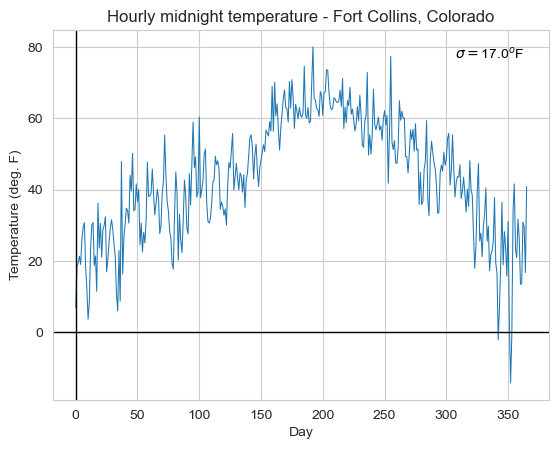

In [3]:
## Plot midnight temperature data for Fort Collins, Colorado
X=data['temp_F']
X_daily=X[::24] ## sample the hourly data every 24 hours
print('minimum data value: ',X_daily.min())
print('maximum data value: ',X_daily.max())
xindex = (np.arange(0,np.size(X),1))/24.
xindex_daily=xindex[::24] ## sample the index every 24 hours
plt.plot(xindex_daily, X_daily, linewidth = 0.75)
v = np.std(X_daily)
plt.text(0.95, 0.925,'$\sigma = $' + str(np.round(v)) + '$^o$F', ha='right', transform=plt.gca().transAxes, color = 'k')
ymin, ymax = plt.ylim();
xmin, xmax = plt.xlim();
lines = plt.plot((xmin, xmax),(0, 0),(0, 0),(ymin, ymax));
plt.setp(lines,color='black', linewidth=1);
plt.ylim((ymin, ymax));
plt.xlim((xmin, xmax));
plt.ylabel('Temperature (deg. F)');
plt.xlabel('Day');
plt.title('Hourly midnight temperature - Fort Collins, Colorado');

In [4]:
#Find the lag-one autocorrelation (AR1)
tseries=X_daily
sigma=np.std(tseries)  ## calculate the standard deviation
mean=np.mean(tseries)  ## calculate the mean
n=len(tseries)         ## calculate the length of the timeseries
lag=1                  ## warning: you cannot change this to be a negative lag. 
                       ## this cell does not work for negative lags - Can you see why?

## remove the mean
tseries1=tseries-mean

##Create two timeseries of the data at t=t1 and t=t2
t1_m=tseries1.iloc[0:-1*lag]
t2_m=tseries1.iloc[lag:]
#print(t1_m.shape)
#print(t2_m.shape)

#Method #1
#Calculate the autocorrelation using numpy correlate lagN
lagNauto_np=np.correlate(t1_m,t2_m,mode='valid')/(n-lag)/(sigma**2)
print('lag',lag,'autocorrelation np.correlate:',round(lagNauto_np[0],3))

#Method #2 - direct calculation
#Calculate the autocorrelation using numpy dot
## (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.dot.html)
lagNauto=np.dot(t1_m,t2_m)/(n-lag)/sigma**2 ## Barnes Chapter 2 Eq. 68 divided by the variance
print('lag',lag,'autocorrelation direct calc:',round(lagNauto,3))

if lag==1: alpha=lagNauto
    
    #you can square the autocorrelation to get variance to help explain an answer

lag 1 autocorrelation np.correlate: 0.846
lag 1 autocorrelation direct calc: 0.846


In [6]:
lagNauto

0.8458699320536965

### 2) Calculate the autocorrelation at a range of lags using np.correlate and the direct method using dot products.  Compare the python syntax for calculating the autocorrelation with the formulas in Barnes.  Equation numbers are provided to refer you back to the Barnes Notes. How does the autocorrelation change as you vary the lag from -40 days to +40 days?

#### Barnes Chapter 2, EQ 68
The autocorvariance function $(\gamma(t))$ is the covariance of a time series with itselt at another time, measured by a time lag (or lead), $\tau$. For a time series $x(t)$, it is defined as:

$$
\gamma(t)=\frac{1}{t_N-\tau} \sum \limits _{t=t_1} ^{t_N-\tau} [x'(t) \cdot x'(t+\tau)] \\ (eq \ 67)
$$

where $t_1$ and $t_N$ are the starting and end points of a time series, respectively, and the prime denotes departures from the long-term mean.

For a continuous time series with time positions, $k=1,2,3...N$:
$$
\gamma(\tau) = \frac{}{x'(t)x'(t+\tau)} \\ (eq \ 68)
$$

and for $\tau = 0$, the autocovariance is $\gamma(0)=\bar{x^{'2}}= \ variance$

The more commonly used autocorrelation, $\rho(\tau)$ is just $\gamma(\tau)$ normallized by $\gamma(0)$. It is simply the correlation of a time series with itself at another time.

Notes on autocorrelation:

- $\gamma$ is symetric about $\tau=0$
- $-1 \leqslant \rho(\tau) \leqslant 1$
- $\rho(0) = 1$
- if the time series is not periodic, $\rho(\tau) \to 0$ as $\tau \to \infty$

#### Answer to Q2:

The autocorrelation at all lags are symmetric around the zero-lag and decrease in autocorellation with lags increasing in 'distance' from the centerpoint.

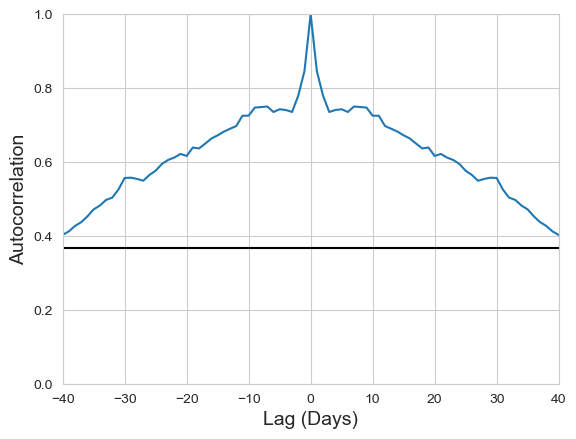

In [20]:
# Calculate the autocorrelation at all lags and plot it
# Is it symmetric about 0 lag?  Should it be? (hint: the answer is yes)
tseries1=tseries-mean
half=int(len(tseries)/2)
lags=np.arange(-1*half,half,1.)
#print(len(tseries1))
#print(len(lags))
#print(len(np.correlate(tseries1,tseries1,mode='same')))
autocorrelation_function=np.correlate(tseries1,tseries1,mode='same')/((n-np.abs(lags))*sigma**2)  ##Eq. 67 divided by variance
plt.plot(range(-1*half,half),autocorrelation_function)
plt.xlim([-40,40]);
plt.ylim([0.0,1.0]);
plt.xlabel('Lag (Days)',fontsize=14);
plt.ylabel('Autocorrelation',fontsize=14);
plt.axhline(1/np.exp(1), c='k', label='1/e, threshold where greater autocorrelation values have less memory')

### 3) Calculate the effective sample size (N*) and compare it to your original sample size (N). Equation numbers are provided to refer you back to the Barnes Notes.  How much memory is there in temperature sampled every midnight?

#### Barnes Chapter 2, 1.3.5: Independent Samples and Effective Sample Size

Sample size N greatly impacts the variance of the sample means. Persistence in a dataset leads to overestimations of the smple size because each data point is not dependent of those around it. 

Consider the T Statistic:
$$
t=\frac {\bar{x}-\mu}{\frac{s}{\sqrt{N-1}}} \\ (eq \ 87)
$$

If we assume no persistence in the red-noise time series, the sample mean SD, $\hat{s} = \frac{s}{{\sqrt{N-1}}}$ wlll be an underestimate and thus the t-statistic will also be over-estimated.

The most convenient way to deal with persistence in your time sesries is to introduce an <i> effective sample size </i>, $N^*$. The estimation of $N^*$ is generally approached assuming that the data follows a first-order autoregressive process (red noise). In this case, $N^*$ can be estimated using the approximation expressed in <b>EQ 88</b>:

$$
\frac{N^*}{N} \cong \frac{1-\rho(\Delta t)}{1+\rho(\Delta t)} \\ see \  Wilks \ pg \ 127 \ for \ more \ info
$$

where N is the number of datapoints in the time series, $\Delta t$ is the time step and $\rho(\Delta t)$ is the autocorrelation at lag 1. 

- for white noise, if $\rho(1)=0, N^* = N$
- as $\rho(1)$ increases, $N^*$ decreases.


#### Answer to Q3: 

The memory can be reference through the autocorrelation associated with a numbered-lag. When we refer to the distribution above and compare it to the 1/e threshold, the autocorrelations between +/-40 days are all above 0.4, which is indicative that there is more influence in red-noise and higher associations with memory. If we look at +/- 1 day lags, these indicate that the previous day's events have a higher influence on the "current" day's observations.

# samples, N:  366
lag-1 autocorrelation:  0.85
#independent samples, N*:  31.0


### 4) Now you are ready to tinker … i.e., make minor adjustments to the code with the parameters set in the code to see how your results change.  Suggestion: Make a copy of the notebook for your tinkering so that you can refer back to your original answers and the unmodified original code. For example: Repeat steps 1-3) above with a different variable (e.g., relative humidity (RH), wind speed (wind_mph)).  Repeat steps 1-3) above with a different temporal sampling frequency (e.g., every 12 hours, every 6 hours, every 4 days).  How do you answers change?  

In [21]:
data

day      hour  temp_F    RH  dewtemp_F  wind_mph  wind_dir  windgust  \
0     42370  0.000000     7.0  72.2       -0.1       1.2       234       3.9   
1     42370  0.041667     5.4  74.3       -1.0       3.4       299       7.1   
2     42370  0.083333     6.4  73.8       -0.2       2.8       200       7.0   
3     42370  0.125000     3.0  73.5       -3.6       2.9       309       6.1   
4     42370  0.166667     3.7  76.9       -1.9       3.1       346       5.3   
...     ...       ...     ...   ...        ...       ...       ...       ...   
8779  42735  0.791667    22.3  74.3       15.4       0.9       221       3.3   
8780  42735  0.833333    20.3  80.4       15.3       0.6       279       2.9   
8781  42735  0.875000    19.9  81.1       15.1       0.5       197       2.5   
8782  42735  0.916667    17.8  82.8       13.5       2.0       353       4.8   
8783  42735  0.958333    16.3  84.1       12.4       1.0       191       4.9   

      windgust_dir  pres_Hg  SOLIN_Wm2  Prec_inches  
0              224   851.30        0.0          0.0  
1              302   850.82        0.0          0.0  
2              301   849.83        0.0          0.0  
3              349   850.69        0.0          0.0  
4              255   848.24        0.0          0.0  
...            ...      ...        ...          ...  
8779           202   833.32        0.0          0.0  
8780           279   833.45        0.1          0.0  
8781           279   833.01        0.1          0.0  
8782           352   832.78        0.1          0.0  
8783           353   832.62        0.0          0.0  

[8784 rows x 12 columns]

minimum data value:  16.0
maximum data value:  91.6


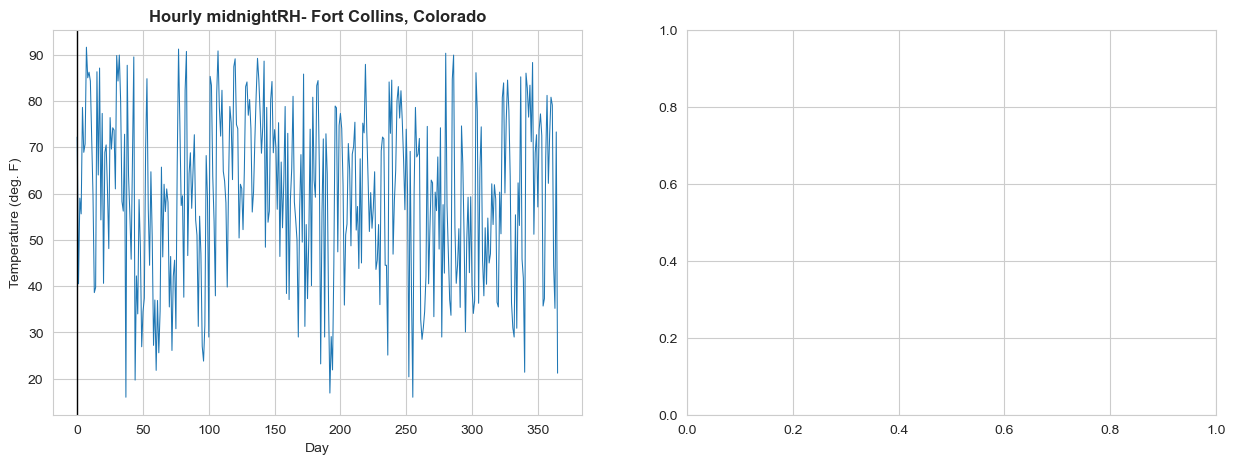

In [ ]:
####

# Part 1
# X=data['RH']
# X_daily=X[::24] ## sample the hourly data every 24 hours
# print('minimum data value: ',X_daily.min())
# print('maximum data value: ',X_daily.max())
# xindex = (np.arange(0,np.size(X),1))/24.
# xindex_daily=xindex[::24] ## sample the index every 24 hours
# plt.plot(xindex_daily, X_daily, linewidth = 0.75)
# v = np.std(X_daily)
# plt.text(0.95, 0.925,'$\sigma = $' + str(np.round(v)) + \
#          '$^o$F', ha='right', transform=plt.gca().transAxes, color = 'k')
# ymin, ymax = plt.ylim();
# xmin, xmax = plt.xlim();
# lines = plt.plot((xmin, xmax),(0, 0),(0, 0),(ymin, ymax));
# plt.setp(lines,color='black', linewidth=1);
# plt.ylim((ymin, ymax));
# plt.xlim((xmin, xmax));
# plt.ylabel('Temperature (deg. F)');
# plt.xlabel('Day');
# plt.title('Hourly midnight RH - Fort Collins, Colorado');

min data value  max data value  Lag-1 Autocorrelation (np)  \
0            16.0            91.6                       0.298   

   Lag-1 Autocorrelation (direct)  # Samples, N  Lag-1 Autocorrelation  \
0                           0.298           366                    0.3   

   # Independent Samples, N$^*$  
0                         198.0

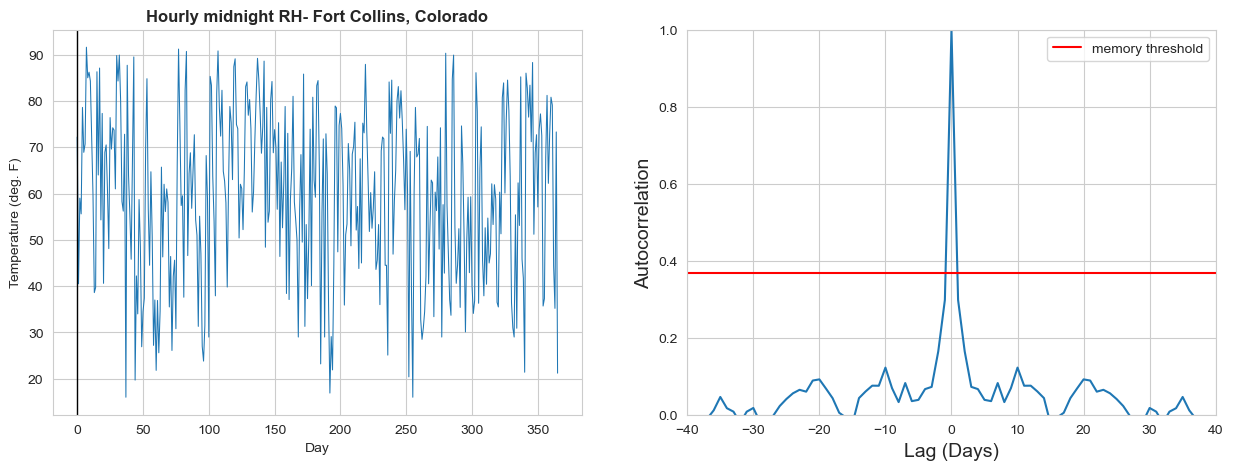

In [40]:
## Plot midnight temperature data for Fort Collins, Colorado

def plotData(df1, variable_str1):
    f, ax = plt.subplots(1,2, figsize=(15,5))
    X = df1
    X_daily=X[::24]
    xindex = (np.arange(0,np.size(X),1))/24.
    xindex_daily=xindex[::24] ## sample the index every 24 hours
    ax[0].plot(xindex_daily, X_daily, linewidth = 0.75)
    v = np.std(X_daily)
    ax[0].text(0.95, 0.925,'$\sigma = $' + str(np.round(v)) + \
             '$^o$F', ha='right', transform=plt.gca().transAxes, color = 'k')
    
    ymin, ymax = ax[0].set_ylim();
    xmin, xmax = ax[0].set_xlim();
    
    lines = ax[0].plot((xmin, xmax),(0, 0),(0, 0),(ymin, ymax));
    plt.setp(lines,color='black', linewidth=1);
    ax[0].set_ylim((ymin, ymax));
    ax[0].set_xlim((xmin, xmax));
    ax[0].set_ylabel('Temperature (deg. F)');
    ax[0].set_xlabel('Day');
    ax[0].set_title('Hourly midnight ' + variable_str1 + '- Fort Collins, Colorado', fontweight='bold')
    
    tseries=X_daily
    sigma=np.std(tseries)  ## calculate the standard deviation
    mean=np.mean(tseries)  ## calculate the mean
    n=len(tseries)         ## calculate the length of the timeseries
    lag=1                  ## warning: you cannot change this to be a negative lag. 
                           ## this cell does not work for negative lags - Can you see why?

    ## remove the mean
    tseries1=tseries-mean

    ##Create two timeseries of the data at t=t1 and t=t2
    t1_m=tseries1.iloc[0:-1*lag]
    t2_m=tseries1.iloc[lag:]
    #print(t1_m.shape)
    #print(t2_m.shape)

    #Method #1
    #Calculate the autocorrelation using numpy correlate lagN
    lagNauto_np=np.correlate(t1_m,t2_m,mode='valid')/(n-lag)/(sigma**2)

    #Method #2 - direct calculation
    #Calculate the autocorrelation using numpy dot
    ## (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.dot.html)
    lagNauto=np.dot(t1_m,t2_m)/(n-lag)/sigma**2 ## Barnes Chapter 2 Eq. 68 divided by the variance

    if lag==1: alpha=lagNauto
    
    #you can square the autocorrelation to get variance to help explain an answer
    
    # Calculate the autocorrelation at all lags and plot it
    # Is it symmetric about 0 lag?  Should it be? (hint: the answer is yes)
    tseries1=tseries-mean
    half=int(len(tseries)/2)
    lags=np.arange(-1*half,half,1.)
    #print(len(tseries1))
    #print(len(lags))
    #print(len(np.correlate(tseries1,tseries1,mode='same')))
    autocorrelation_function=np.correlate(tseries1,tseries1,mode='same')/((n-np.abs(lags))*sigma**2)  ##Eq. 67 divided by variance
    ax[1].plot(range(-1*half,half),autocorrelation_function)
    ax[1].set_xlim([-40,40]);
    ax[1].set_ylim([0.0,1.0]);
    ax[1].set_xlabel('Lag (Days)',fontsize=14);
    ax[1].set_ylabel('Autocorrelation',fontsize=14);
    ax[1].axhline(1/np.exp(1), c='red', label='memory threshold')
    ax[1].legend()
    
    ## Calculate the effective sample size (N*) for this data 
    ## Compare your estimate of the number of independent samples (N*) with the number of samples 
    ## in your original data (N)
    N=len(tseries)
    ## Note that the value of the autocorrelation used in Eq. 88 should be the absolute value otherwise
    ## if alpha is negative you end up with more independent samples than original samples


    N_star = (1-np.abs(alpha))/(1+np.abs(alpha))*N
    
    values = {'min data value': [X_daily.min()], 
              'max data value'  : [X_daily.max()], 
              'Lag-1 Autocorrelation (np)': [round(lagNauto_np[0],3)],
              'Lag-1 Autocorrelation (direct)'  : [round(lagNauto,3)], 
              '# Samples, N': [N], 
              'Lag-1 Autocorrelation': [round(alpha,2)],
              '# Independent Samples, N$^*$': [round((1-np.abs(alpha))/(1+np.abs(alpha))*N,0)]}

    table = pd.DataFrame(data=values)
    table
    
    return table
    
plotData(data['RH'], 'RH')

RH is a little white-noisy but with some kind of pattern. When we look at the autocorrelation this helps validate my thoughts because autocorrelation coefficients associated with lags further from zero are relatively low...so it's pinkish.

In [45]:
variable = ['temp_F', 'RH', 'dewtemp_F','wind_mph', \
            'wind_dir', 'windgust','windgust_dir', \
            'pres_Hg', 'SOLIN_Wm2', 'Prec_inches' ]

min data value  max data value  Lag-1 Autocorrelation (np)  \
0           -19.4            58.7                       0.851   

   Lag-1 Autocorrelation (direct)  # Samples, N  Lag-1 Autocorrelation  \
0                           0.851           366                   0.85   

   # Independent Samples, N$^*$  
0                          30.0

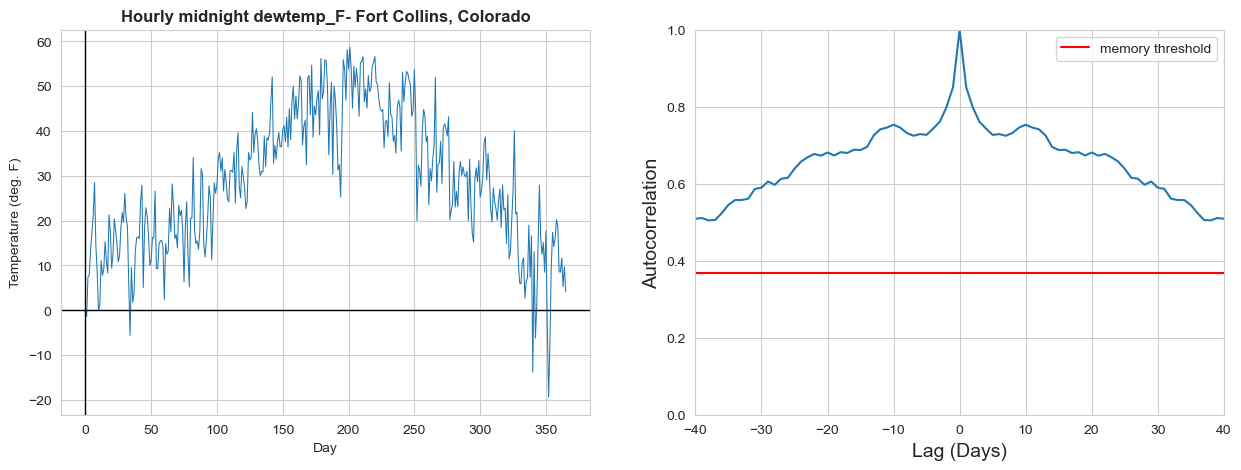

In [52]:
plotData(data['dewtemp_F'], 'dewtemp_F')

Hourly DPT does look more red-noisy which I could expected as there's some kind of transition from temperature changes. This helps validate this through statistics.

min data value  max data value  Lag-1 Autocorrelation (np)  \
0             0.0            30.6                      -0.045   

   Lag-1 Autocorrelation (direct)  # Samples, N  Lag-1 Autocorrelation  \
0                          -0.045           366                  -0.04   

   # Independent Samples, N$^*$  
0                         335.0

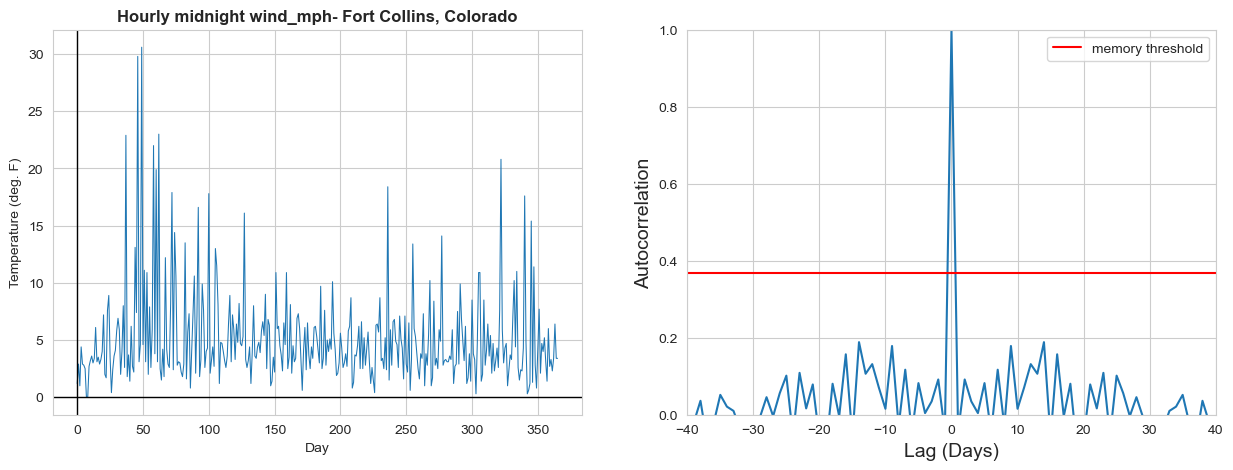

In [53]:
plotData(data['wind_mph'], 'wind_mph')

Wind speeds appear to be more red-noisy with some peaks. But they don't really have a relationship as dependent on memory. I think this is because this is more influenced by pressure changes and temperature.

min data value  max data value  Lag-1 Autocorrelation (np)  \
0               1             359                        0.06   

   Lag-1 Autocorrelation (direct)  # Samples, N  Lag-1 Autocorrelation  \
0                            0.06           366                   0.06   

   # Independent Samples, N$^*$  
0                         325.0

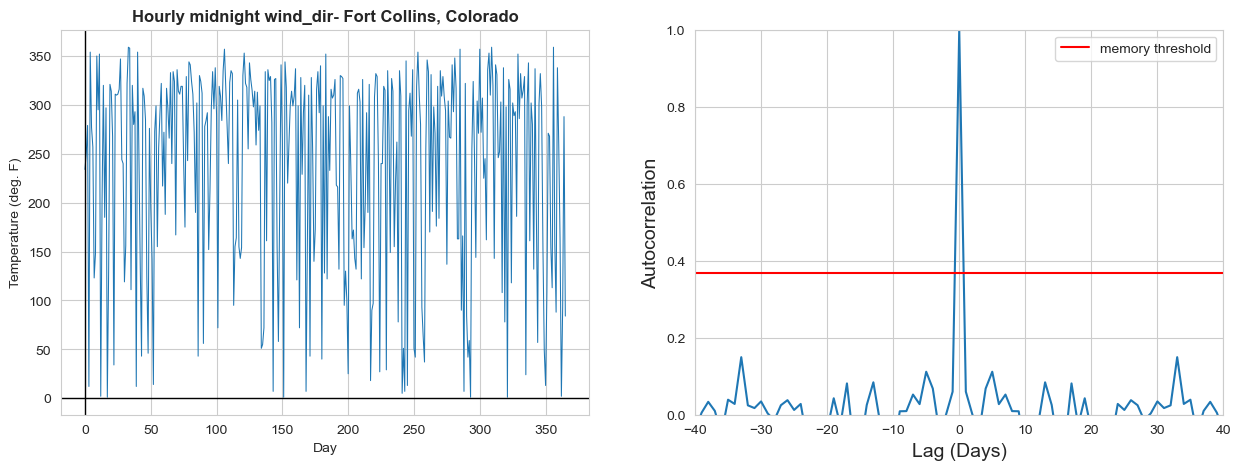

In [60]:
plotData(data['wind_dir'], 'wind_dir')

Similar thoughts on wind direction.

min data value  max data value  Lag-1 Autocorrelation (np)  \
0             0.0            55.8                      -0.024   

   Lag-1 Autocorrelation (direct)  # Samples, N  Lag-1 Autocorrelation  \
0                          -0.024           366                  -0.02   

   # Independent Samples, N$^*$  
0                         349.0

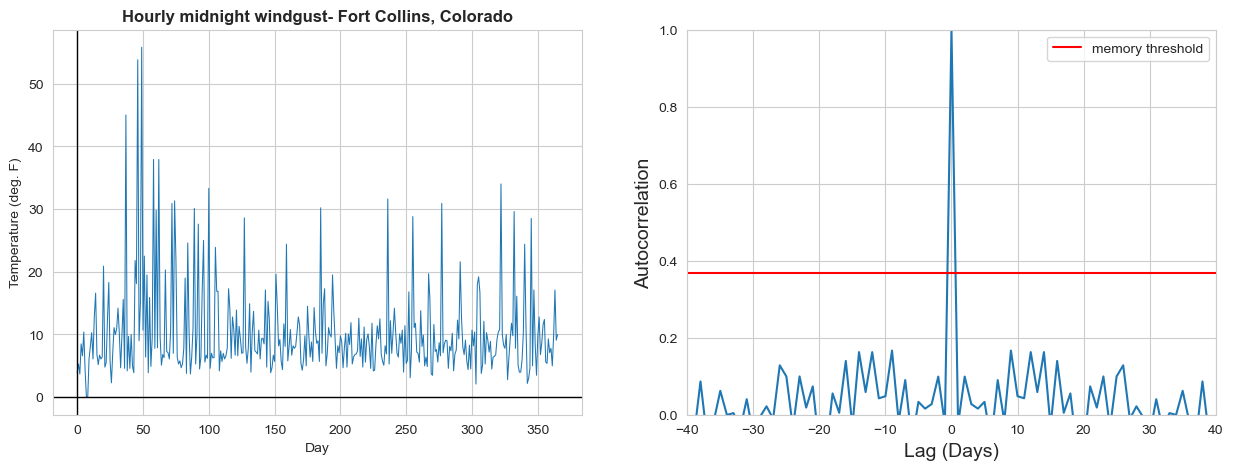

In [61]:
plotData(data['windgust'], 'windgust')

Similar thoughts on wind direction.

min data value  max data value  Lag-1 Autocorrelation (np)  \
0               0             359                         0.0   

   Lag-1 Autocorrelation (direct)  # Samples, N  Lag-1 Autocorrelation  \
0                             0.0           366                    0.0   

   # Independent Samples, N$^*$  
0                         366.0

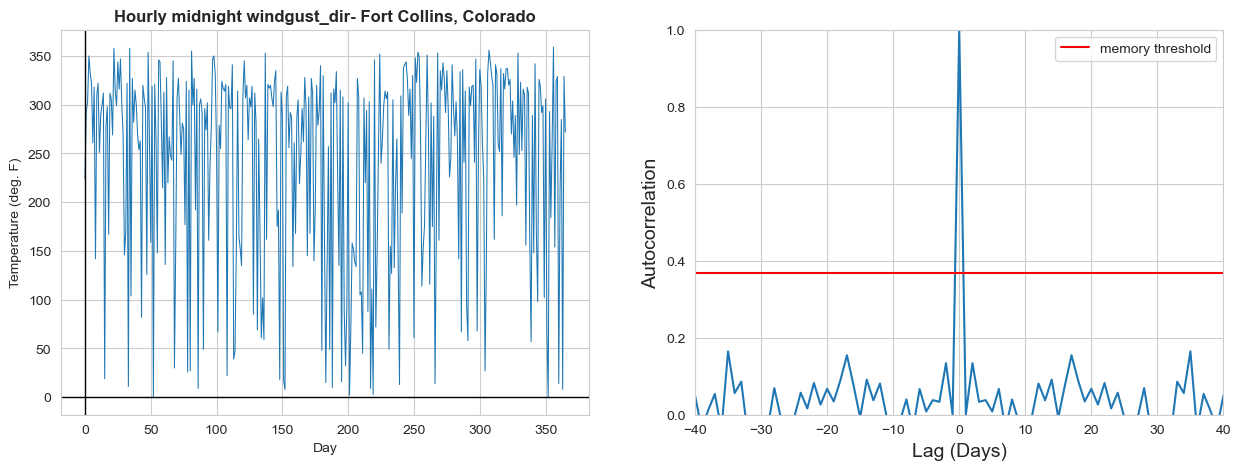

In [56]:
plotData(data['windgust_dir'], 'windgust_dir')

Similar thoughts on wind direction.

min data value  max data value  Lag-1 Autocorrelation (np)  \
0           821.4          855.09                       0.535   

   Lag-1 Autocorrelation (direct)  # Samples, N  Lag-1 Autocorrelation  \
0                           0.535           366                   0.54   

   # Independent Samples, N$^*$  
0                         111.0

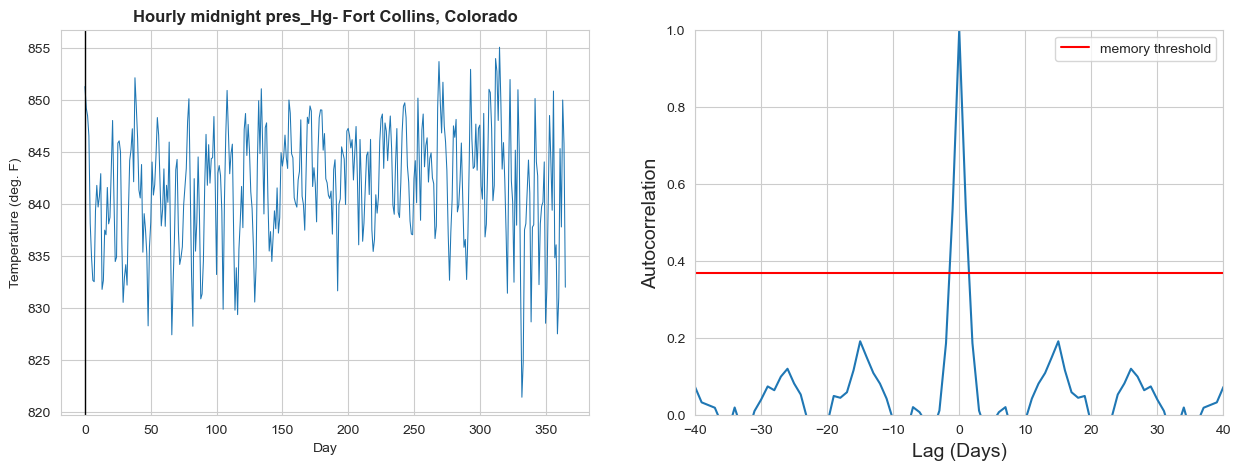

In [57]:
plotData(data['pres_Hg'], 'pres_Hg')

min data value  max data value  Lag-1 Autocorrelation (np)  \
0             0.0             1.7                       0.306   

   Lag-1 Autocorrelation (direct)  # Samples, N  Lag-1 Autocorrelation  \
0                           0.306           366                   0.31   

   # Independent Samples, N$^*$  
0                         194.0

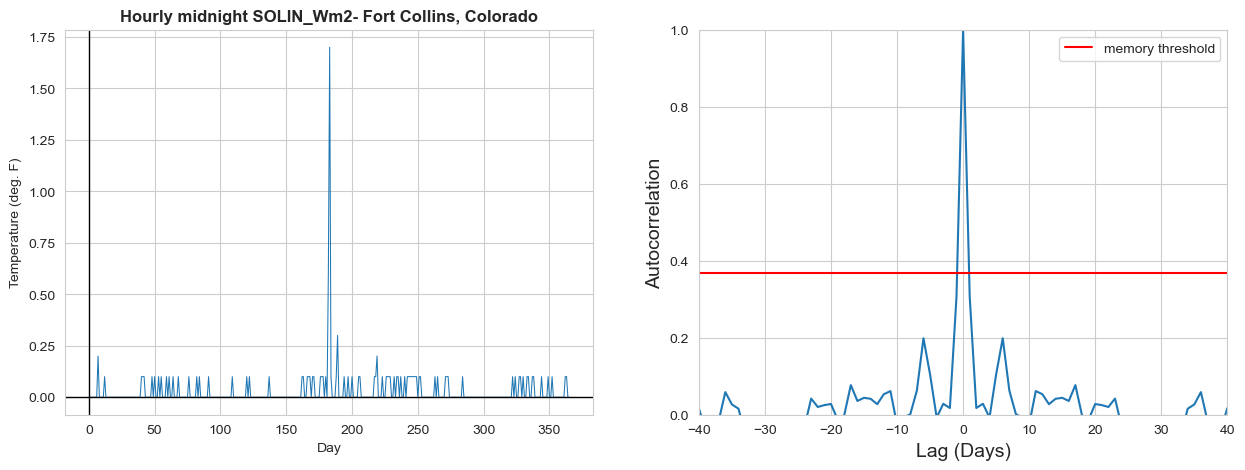

In [58]:
plotData(data['SOLIN_Wm2'], 'SOLIN_Wm2')

min data value  max data value  Lag-1 Autocorrelation (np)  \
0             0.0            0.12                      -0.001   

   Lag-1 Autocorrelation (direct)  # Samples, N  Lag-1 Autocorrelation  \
0                          -0.001           366                   -0.0   

   # Independent Samples, N$^*$  
0                         366.0

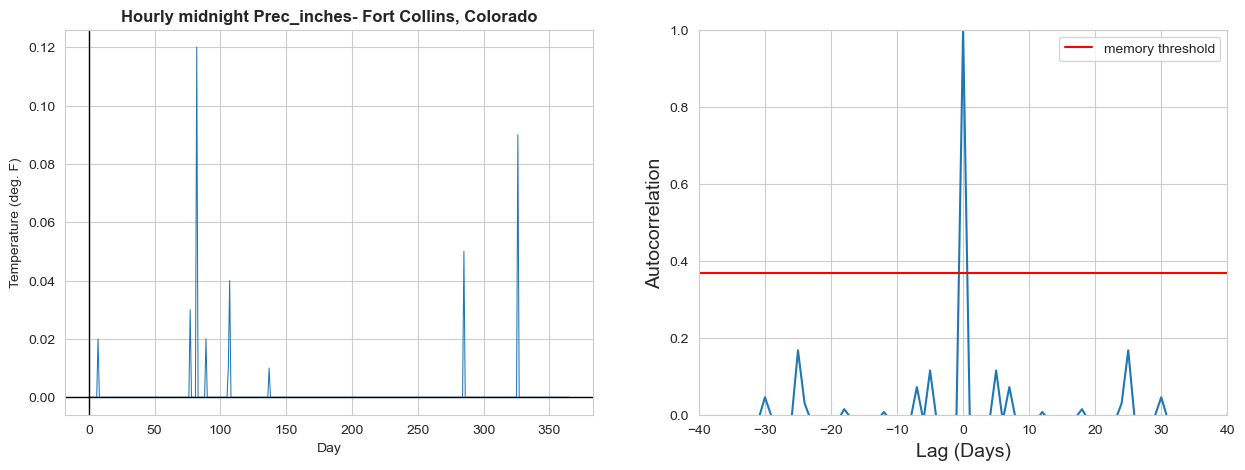

In [59]:
plotData(data['Prec_inches'], 'Prec_inches')

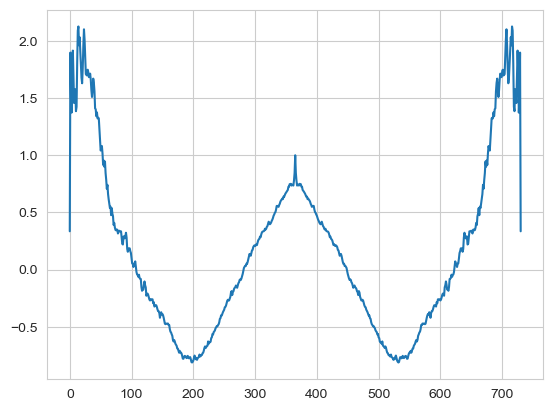

In [12]:
#### EXTRA

## Unsolved mystery of ATOC5860 -- If you want to plot the full autocorrrelation (i.e., vs. all lags)
## You end up with values greater than 1.  But the autocorrelation should be between -1 and 1 (??)

lags_full=np.arange(-n+1,n);
foo=np.correlate(tseries1,tseries1,mode='full')/((n-np.abs(lags_full))*sigma**2);
plt.plot(foo);

## Potential solution??
## Autocorrelation maybe needs to use variance from only the part of the data that are being used?
## Look at Wilks page 58.